<h1 style='color:purple' align='center'>Data Science Regression Project: Predicting Home Prices in Banglore</h1>

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
# will randomize our sample so that each of the fold have equal distribution
from sklearn.model_selection import ShuffleSplit

from sklearn.model_selection import cross_val_score

In [6]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

<h2 style='color:blue'>Data Load: Load Banglore House Prices into a dataframe</h2>

In [7]:
data = pd.read_csv('House_Data.csv')
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [8]:
data.shape

(13320, 9)

## Data Cleaning

In [9]:
# data.groupby('area_type')['area_type'].agg('count')

data['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

**Drop features that are not required to build our model**

In [10]:
data = data.drop(['area_type','availability','society','balcony'],axis=1)

In [11]:
data.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


<h2 style='color:blue'>Data Cleaning: Handle NA values</h2>

In [12]:
data.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [13]:
data = data.dropna()
data.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [14]:
data['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

<h2 style='color:blue'>Feature Engineering</h2>

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [15]:
data['bhk'] = data['size'].apply(lambda x : int(x.split(' ')[0]))
data.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [16]:
data['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [17]:
data['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

**We can see that we have range values in total_sqft column**

In [18]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    
    return True

In [19]:
data[ ~data['total_sqft'].apply(is_float) ].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


**total_sqft column has different ranges values also like :**
   - 1015 - 1540
   - 34.46Sq. Meter
   - 4125Perch

In [20]:
def convert_sqft_to_num(x):
    
    tokens = x.split('-')
    if len(tokens)==2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    
    
    try:
        return float(x)
    except:
        return None

In [21]:
convert_sqft_to_num('2166')

2166.0

In [22]:
convert_sqft_to_num('2100-2850')

2475.0

In [23]:
convert_sqft_to_num('34.46Sq. Meter')

In [24]:
data['total_sqft'] = data['total_sqft'].apply(convert_sqft_to_num)
data.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [25]:
data.loc[30]

location      Yelahanka
size              4 BHK
total_sqft         2475
bath                  4
price               186
bhk                   4
Name: 30, dtype: object

## Feature Eng

**Add new feature called price per square feet**

In [26]:
data['price_per_sqft'] = data['price']*100000/data['total_sqft']
data.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [27]:
len(data['location'].unique())

1304

In [28]:
location_counts = data['location'].value_counts(sort=True)
location_counts

Whitefield                                         534
Sarjapur  Road                                     392
Electronic City                                    302
Kanakpura Road                                     266
Thanisandra                                        233
                                                  ... 
KAMAKIYA                                             1
Chikkabidarakallu                                    1
SK Garden                                            1
Sampangirama Nagar                                   1
12th cross srinivas nagar banshankari 3rd stage      1
Name: location, Length: 1304, dtype: int64

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [29]:
len( location_counts[location_counts<=10] )

1063

In [30]:
location_counts_lessthan_10 = location_counts[location_counts<=10]

In [31]:
data['location'] = data['location'].apply(lambda x:'Other'  if x in location_counts_lessthan_10 else x )

In [32]:
len(data['location'].unique())

242

<h2 style="color:blue">Outlier Removal Using Business Logic</h2>

**As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [33]:
outlier1 = data[ data['total_sqft']/data['bhk'] < 300]
len(outlier1)

744

In [34]:
data.shape

(13246, 7)

In [35]:
data = data[~(data['total_sqft']/data['bhk'] < 300)]
data.shape

(12502, 7)

<h2 style='color:blue'>Outlier Removal Using Standard Deviation and Mean</h2>

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [36]:
data['price_per_sqft'].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [37]:
def remove_pps_outliers(data):
    df = pd.DataFrame()
    
    for key,sub_df in data.groupby('location'):
        m  = np.mean(sub_df['price_per_sqft'])
        st = np.std(sub_df['price_per_sqft'])
        
        reduced_df = sub_df[ (sub_df['price_per_sqft']>(m-st)) & (sub_df['price_per_sqft']<(m+st))]
        df = pd.concat([df ,reduced_df] ,ignore_index=True)
        
    return df

In [38]:
data = remove_pps_outliers(data)
data.shape

(10244, 7)

In [39]:
data['location'].unique()

array([' Devarachikkanahalli', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout',
       '5th Phase JP Nagar', '6th Phase JP Nagar', '7th Phase JP Nagar',
       '8th Phase JP Nagar', '9th Phase JP Nagar', 'AECS Layout',
       'Abbigere', 'Akshaya Nagar', 'Ambalipura', 'Ambedkar Nagar',
       'Amruthahalli', 'Anandapura', 'Ananth Nagar', 'Anekal',
       'Anjanapura', 'Ardendale', 'Arekere', 'Attibele', 'BEML Layout',
       'BTM 2nd Stage', 'BTM Layout', 'Babusapalaya', 'Badavala Nagar',
       'Balagere', 'Banashankari', 'Banashankari Stage II',
       'Banashankari Stage III', 'Banashankari Stage V',
       'Banashankari Stage VI', 'Banaswadi', 'Banjara Layout',
       'Bannerghatta', 'Bannerghatta Road', 'Basavangudi',
       'Basaveshwara Nagar', 'Battarahalli', 'Begur', 'Begur Road',
       'Bellandur', 'Benson Town', 'Bharathi Nagar', 'Bhoganhalli',
       'Billekahalli', 'Binny Pete', 'Bisuva

In [40]:
def scatter_plot(data ,location):
    
    bhk2 = data[ (data['location']==location) & (data['bhk']==2) ]
    bhk3 = data[ (data['location']==location) & (data['bhk']==3) ]
    
    plt.scatter(bhk2['total_sqft'] ,bhk2['price'] ,marker='*' ,color='blue' ,label='2 BHK' ,s=50)
    plt.scatter(bhk3['total_sqft'] ,bhk3['price'] ,marker='+' ,color='green' ,label='3 BHK' ,s=50)
    
    plt.xlabel('Toatl Square Feet Area')
    plt.ylabel('Price')
    
    plt.title(location)
    
    plt.legend()

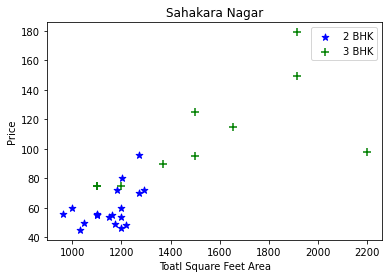

In [41]:
scatter_plot(data ,'Sahakara Nagar')

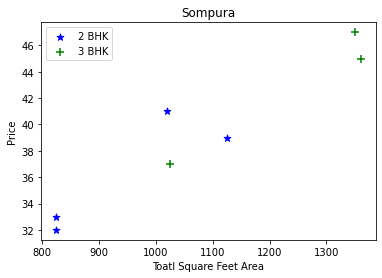

In [42]:
scatter_plot(data ,'Sompura')

- We remove properties where for same location ,the price of 3bedroom apartment is less than 2 bedroom apartment
- We remove those 2BHK apartment whose price_per_sqft is less than mean price_per_sqft of 1BHK apartment

In [43]:
def remove_bhk_outliers(data):
    
    exlude_indexes = np.array([])
    
    for loc,loc_df in data.groupby('location'):
        
        bhk_stats = {}
        for bhk,bhk_df in loc_df.groupby('bhk'):
            bhk_stats[bhk] = {
                               'mean' : np.mean(bhk_df['price_per_sqft']),
                               'std'  : np.std(bhk_df['price_per_sqft']) ,
                               'count': bhk_df.shape[0]
                             }
        
        for bhk,bhk_df in loc_df.groupby('bhk'):
            
            # get 1 less bedroom details e.g if we are at 3bhk get details of 2bhk
            stats = bhk_stats.get(bhk-1)
            
            if stats and stats['count']>5:
                exlude_indexes = np.append(exlude_indexes ,bhk_df[bhk_df['price_per_sqft']< stats['mean']].index.values )
                
    return data.drop(exlude_indexes ,axis='index')

In [44]:
data = remove_bhk_outliers(data)

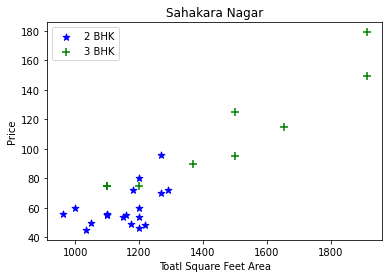

In [45]:
scatter_plot(data ,'Sahakara Nagar')

Text(0, 0.5, 'Count')

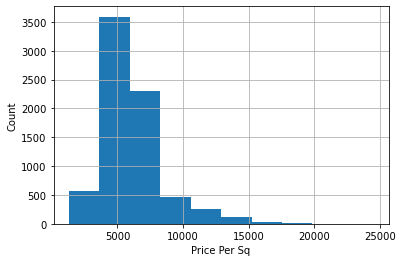

In [46]:
data['price_per_sqft'].hist()

plt.xlabel('Price Per Sq')
plt.ylabel('Count')

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [47]:
data['bath'].unique()

array([ 2.,  3.,  4.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [48]:
data[data['bath']>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5271,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
5924,Other,10 BHK,12000.0,12.0,525.0,10,4375.000000
6013,Other,16 BHK,10000.0,16.0,550.0,16,5500.000000
6752,Other,11 BHK,6000.0,12.0,150.0,11,2500.000000
7084,Other,13 BHK,5425.0,13.0,275.0,13,5069.124424


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

Text(0, 0.5, 'Count')

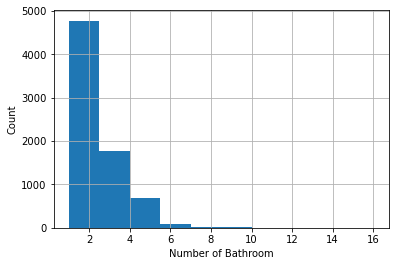

In [49]:
data['bath'].hist()

plt.xlabel('Number of Bathroom')
plt.ylabel('Count')

In [50]:
data[ data['bath']>data['bhk']+2 ]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1637,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5232,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
5848,Other,6 BHK,11338.0,9.0,1000.0,6,8819.897689
9016,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330


In [51]:
data = data[ data['bath']<data['bhk']+2 ]
data.shape

(7264, 7)

In [52]:
data = data.drop(['size','price_per_sqft'] ,axis=1)

## Model Building

In [53]:
dummies = pd.get_dummies(data['location'],drop_first=True)

In [54]:
data = pd.concat([data,dummies],axis=1)

In [55]:
data = data.drop(['location'] ,axis=1)

In [56]:
X = data.drop(['price'],axis=1)
y = data['price']

In [57]:
X_train ,X_test ,y_train ,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

### Model 1

In [58]:
lr_clf = LinearRegression()

lr_clf.fit(X_train ,y_train)

LinearRegression()

In [59]:
lr_clf.score(X_test ,y_test)

0.8501508658045782

### Model 2

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [60]:
cv = ShuffleSplit(n_splits=5 ,test_size=0.2 ,random_state=0)
cross_val_score(LinearRegression(),X,y,cv=cv)

array([0.85015087, 0.85327657, 0.88701488, 0.79792361, 0.80742688])

### Model 3

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [61]:
def find_best_model(X,y) :
    algos = {
             'linear_regression' : {
                                     'model': LinearRegression(),
                                     'params': {
                                                'normalize': [True, False]
                                               }
                                   },
             'lasso'             : {
                                     'model': Lasso(),
                                     'params': {
                                                 'alpha': [1,2],
                                                  'selection': ['random', 'cyclic']
                                               }
                                    },
             'decision_tree'      : {
                                      'model': DecisionTreeRegressor(),
                                      'params': {
                                                 'criterion' : ['mse','friedman_mse'],
                                                 'splitter': ['best','random']
                                                 }
                                    }
             }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    
    for algo_name, config in algos.items():
        
        gs =  GridSearchCV( config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        
        scores.append({
                        'model': algo_name,
                        'best_score': gs.best_score_,
                        'best_params': gs.best_params_
                      })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [62]:
find_best_model(X,y)

,model,best_score,best_params
0,linear_regression,0.839159,{'normalize': True}
1,lasso,0.729984,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.732912,"{'criterion': 'mse', 'splitter': 'best'}"


In [63]:
X.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)

In [64]:
np.where(X.columns=='bhk')[0][0]

2

<h2 style='color:blue'>Test the model for few properties</h2>

In [65]:
def predict_price(location ,sqft ,bath ,bhk) :
    
    # getting column index
    loc_index = np.where(X.columns==location)[0][0]
    
    x = np.zeros( len(X.columns) )
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    
    if loc_index>=0:
        x[loc_index] = 1
    
    
    return lr_clf.predict([x])[0]

In [66]:
predict_price('1st Phase JP Nagar' ,1000 ,2 ,2)

84.65706883790097

In [67]:
predict_price('1st Phase JP Nagar' ,1000 ,2 ,3)

83.67723715756733

In [68]:
predict_price('1st Phase JP Nagar' ,1000 ,3 ,3)

86.29871859215265

In [69]:
predict_price('Indira Nagar' ,1000 ,2 ,2)

163.19124401823268

In [70]:
predict_price('Indira Nagar' ,1000 ,3 ,3)

164.83289377248434

In [71]:
predict_price('Indira Nagar' ,1000 ,2 ,3)

162.21141233789902